# Implementation of PLSI algorithm using Spark 

In [2]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import findspark
findspark.init(
    "/Users/gaelleguillou/Desktop/Database management/spark-2.2.3-bin-hadoop2.7"
)
import pyspark
from numpy import random
import math
from pyspark import sql

## 1. Prepare the environment

### Import the data

We will implement the PLSI algorithm on the Movielens dataset. To simplify our task, we will start by implementing the PLSI algorithm on a reduced version of the Movielens dataset ("ratings_short"), which contains 100 836 observations. 

In [3]:
ratings_data = pd.read_csv("ratings.csv")
ratings_data.head()

,user_id,user_username,movie_id,rating
0,2,William,1768,1
1,3,James,615,3
2,7,Joseph,82,3
3,7,Joseph,532,3
4,8,Thomas,698,3


**Description of the dataset :** 
- userId, to characterize the users 
- movieId, to characterize the movies
- rating : the rating of the user to the corresponding movie. Ratings are going from 1 to 5 but here we will only use the seen / not seen information to provide movie recommendations.  
- timestamp : we will not be using this column

More information about the movies are available in the "movies.csv" dataset : the movieId gives us access to the corresponding movie information such as the title and the genres. 

In [4]:
movies = pd.read_csv("movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
movies.shape

(9742, 3)

### Create a Spark environment

!sudo hostname

In [6]:
sc = pyspark.SparkContext()

To be able to implement the PLSI algorithm in Spark, we will need to transform the dataset into an RDD, and then perform pyspark operations on it. 

In [7]:
rdd = sc.textFile("ratings.csv")

#Remove header line
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

rdd.collect()[0:10]

['2,William,1768,1',
 '3,James,615,3',
 '7,Joseph,82,3',
 '7,Joseph,532,3',
 '8,Thomas,698,3',
 '10,Robert,1693,3',
 '11,Edward,615,1',
 '18,David,1,3',
 '18,David,28,3',
 '18,David,1596,5']

In [8]:
rdd.count()

295

## 2. Probabilistic Latent Semantic Indexing algorithm (PLSI)

The PLSI algorithm that we will implement here is based on Das description of the Google News recommendation system. The algorithm is based on the following model : 
- u (users) and s (movies) are random variables 
- The relationship between users and movies is learned by modeling the joint distribution of users and items as a mixture distribution 
- To capture this relationship, we introduce a hidden variable z (latent variable), that kind of represents user communities (same preferences) and movie communities (sames genres). 

All in all, we try to compute the following probability for each (user, movie) couple : p(s|u) = sum(p(s|z)p(z|u)), which is the probability for a given user to see a given movie. This is obtained by summing for each community the probability for a movie s to be seen given a community z times the probability to be in the community z given a user u. 

### Going through the algorithm : main steps

**INITIALISATION**

**E-STEP - Compute q( z | (u,s) ) : the probability that the (user, movie) couple belongs to the class z**
This step is first initialized at random :
- To each couple (u,s), assign each possible community 
- Ex with number of classes = 2 : the lines (Marie, Star Wars) and (Gaëlle, Matrix) will give (Marie, Star Wars, 1), (Marie, Star Wars, 2), (Gaëlle, Matrix, 1), (Gaëlle, Matrix, 2)
- To each line, assign a random probability. This random probability corresponds to q*( z | (u,s) ). For example if I have (Marie, Star Wars, 1, 0.3), then the probability that the couple (Marie, Star Wars) is in class 1 is 0.3. 

LogLik = 0

**ITERATION**

**M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) )**
- Compute p(s | z) :  sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z
- Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u

**E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u)**
- For each (u,s,z), compute p(s | z) * p(z | u)
- For each (u,s), compute ∑ p(s | z)* p(z | u) (summing over z)     ***(this corresponds to p(s|u))***
- For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u)             ***(this corresponds to the new q( z | (u,s) )***
	    
**Update LogLik** = sum( log( ∑ p(s | z) * p(z | u))) = sum( log (p(s | u))

**Iterate again until LogLik converges** : this means that it has reached its maximum and we have found the best estimation of p(z | u) and p(s | z).
	    
**We can now predict the probability that Gaëlle will watch Star Wars** :
p(Star Wars | Gaëlle) = p( 1 | Gaëlle) * p(Star Wars |1) + p(2 | Gaëlle) * p(Star Wars | 2)

### Implementing the algorithm 

Keep only (user, movie) information : 

In [9]:
rdd = rdd.map(lambda line: line.split(',')).map(lambda line: line[0] + ',' +
                                                line[2])

#### Initialisation of q : (first E-Step)

To each couple (u,s), assign each possible community z : 

In [10]:
nb_z = 3  #number of classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

In [11]:
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x: (x[
    0][0], x[0][1], x[1]))
ordered_rdd.count()

882

To each line, assign a random probability :

In [12]:
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = (proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten()
random_p = list(random_p)

In [13]:
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 

In [14]:
q.count()

882

#### One iteration step 

M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) )

Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z

In [15]:
SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))

In [16]:
Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)

In [17]:
Z_probas = q.map(lambda x: (x[0][1], x[1]))

In [18]:
Nz = Z_probas.reduceByKey(lambda x,y: x+y)

In [19]:
Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))

In [20]:
Psz = Nsz.join(Nz)

In [21]:
Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1]))

Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u

In [22]:
ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))

In [23]:
Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)

In [24]:
U_probas = q.map(lambda x: (x[0][0][0], x[1]))

In [25]:
Nu = U_probas.reduceByKey(lambda x,y: x+y)

In [26]:
Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))

In [27]:
Pzu = Nzu.join(Nu)

In [28]:
Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1]))

E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u)

For each (u,s,z), compute p(s | z) * p(z | u)

In [29]:
q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))

In [30]:
q_int2 = q_int.join(Pzu)

In [31]:
q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))

In [32]:
PzuPsz = q_int3.join(Psz)

In [33]:
PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))

For each (u,s), compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u))

In [34]:
SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)

For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )

In [35]:
q1 = PzuPsz.join(SumPzuPsz)

In [36]:
q1 = q1.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))

Update LogLik = sum( log( ∑ p(s | z) * p(z | u))) = sum( log (p(s | u))

In [37]:
log = SumPzuPsz.map(lambda x : np.log(x[1]))
LogLik = log.reduce(lambda x,y : x+y)

End of the iteration step 

### Full Algorithm 

In [38]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 3 
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_3 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_3.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.7041632380604903
-3.6413668189342316
-3.5079498564437643
-3.2995767967786787
-3.1067433576020473
-2.9980522537451186
-2.9358344004304686
-2.8924337905629796
-2.8662907628801997
-2.851740402312338
-2.843590824753671
-2.8388056909876553
-2.8362704069421065
-2.834730853907843
-2.8336038002979773
-2.8327219488072117
-2.832013809979426
-2.831375339090984
-2.8306567822542736
-2.829694526298586
-2.828443762490682
-2.8272130101405035
-2.8264136447109216
-2.8260378467373126
-2.8258743136537703
-2.8257939445406914
-2.8257474914156653
-2.8257173002135985
-2.825696196459741
-2.825680778404163


### Plot the LogLikelihood

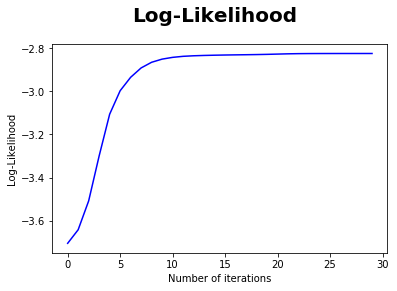

In [39]:
fig = plt.figure()
fig.suptitle('Log-Likelihood', fontsize=20, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Log-Likelihood')
ax.plot(LogLik_3, 'b')
plt.savefig('loglik_3_clusters_30_iterations.png')
plt.show()

### Test different numbers of clusters 

With z = 4 : 

In [58]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 4
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_4 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_4.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.6944701572096075
-3.6235998116371526
-3.4817478932247687
-3.2742113149540732
-3.077450057916022
-2.939614498029178
-2.839171478335526
-2.7440072643861315
-2.660843607381408
-2.6059024698507787
-2.58048810278408
-2.5708750047356763
-2.5662146912622354
-2.562161131066387
-2.559419086533915
-2.5580719875257167
-2.5571407414382974
-2.5561267558707286
-2.5549723927555106
-2.5537947336238833


With z = 5 : 

In [59]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 5 
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_5 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_5.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.6983076515267768
-3.616302309239121
-3.45118266719432
-3.204207848160514
-2.927697094727986
-2.7124388072735885
-2.5919016334699143
-2.52558005299916
-2.4887329891607335
-2.460872041837954
-2.4356930529939316
-2.421700219738211
-2.413292456442617
-2.4060191451905113
-2.4009067561469695
-2.3984889311037776
-2.39762726317057
-2.3971810207555615
-2.3969087137261424
-2.3967354356115274


With z = 10 : 

In [60]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 10 
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_10 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_10.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.6865383577686712
-3.591067186534691
-3.371902460895129
-2.9931270673959243
-2.569702017872299
-2.228048659081242
-2.014784325715848
-1.9026239979794344
-1.8361327768023834
-1.7923968040965421
-1.7683964504106846
-1.7588563487780227
-1.7542579131079128
-1.7518131484499917
-1.750202562500243
-1.7491860470975078
-1.7485475925469602
-1.7480666600985177
-1.747638599927523
-1.7472348573850487


With z = 15 : 

In [61]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 15
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_15 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_15.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.691133635256291
-3.5989671168500066
-3.3713602802036333
-2.915082468570563
-2.3301544291329015
-1.8768835112189564
-1.6329644144035378
-1.5337187008050606
-1.4944064590130925
-1.4725967786421175
-1.4612987404253215
-1.456654937898405
-1.4541458064835096
-1.4522137204900432
-1.4508023735124875
-1.450020463863261
-1.4495184117180102
-1.4489957379153893
-1.448238078850041
-1.4470312843216342


With z = 20 : 

In [62]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 20
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_20 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_20.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.6900182598151647
-3.6002243765776307
-3.3798748494266193
-2.928555290753391
-2.3252974111520386
-1.8152461348103381
-1.5048494850453087
-1.3404719996392902
-1.247582206795833
-1.198046723096243
-1.1753554860405981
-1.1601384959757302
-1.1469780263332248
-1.140588795174602
-1.138809009478394
-1.1379759961380527
-1.1374669471014365
-1.1371131992395305
-1.136843290390053
-1.136614386365913


In [63]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 25
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_25 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_25.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.6960468810973612
-3.6142796497827003
-3.407190216121806
-2.973340412707448
-2.3432511844456854
-1.7742228907406525
-1.4207359912074486
-1.2402982857456457
-1.1431255210786815
-1.0879504763134105
-1.0598514363375886
-1.0436124991930418
-1.0313575424467174
-1.019378414451212
-1.0072623111316168
-0.9964859367326563
-0.9907800660217402
-0.9887710854797862
-0.9872771424243436
-0.9860444818864411


In [64]:
#Open rdd

rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)

#Keep only (user, movie) information
rdd = rdd.map(lambda line : line.split(',')).map(lambda line : line[0] + ',' + line[2])

#Initialize number of classes and number of iteratins
nb_z = 30
nb_iterations = 20

#Compute the cartesian product of the (user, movie) couples with the 3 classes
classes = sc.parallelize(range(nb_z))
classes.collect()
rdd = rdd.cartesian(classes)
rdd = rdd.distinct()

## Initialize q0 ##

#Order rdd by user, movie, class
ordered_rdd = rdd.map(lambda x: (x[0].split(','), x[1])).sortBy(lambda x : (x[0][0], x[0][1], x[1])) 

#Create a vector of probabilities that sum to 1 every nb_z probas
proba0 = np.random.rand(int(ordered_rdd.count()/nb_z), nb_z)
random_p = list((proba0 / np.reshape(proba0.sum(1), (int(ordered_rdd.count()/nb_z), 1))).flatten())

#Assign a probability to each triplet (user, movie, class)
q = ordered_rdd.map(lambda x : (x, random_p.pop(0))) 
num_partitions = q.getNumPartitions()

#Create an empty list to keep track of the LogLikelihood
LogLik_30 = []

###### Run the EM algorithm on nb_iterations #####

for i in range(nb_iterations) : 
    
    #### M-STEP - Compute p(s|z) and p(z|u) based on q( z | (u,s) ) ####
    
    ## Compute p(s | z) : sum the probas associated to every couple (s,z) and divide it by the sum of probas associated to this z ##
    
    #Keep the probabilities of all the (movie, class) couples 
    SZ_probas = q.map(lambda x: ((x[0][0][1], x[0][1]), x[1]))
    
    #Sum the probabilities for the same (movie, class) couples
    Nsz = SZ_probas.reduceByKey(lambda x,y: x + y)
    
    #Keep the probabilities associated to each class in the rdd and sum the probabilities by class
    Z_probas = q.map(lambda x: (x[0][1], x[1]))
    Nz = Z_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (movie, class) couple by the probability of the class
    Nsz = Nsz.map(lambda x : (x[0][1], (x[0][0], x[1])))
    Psz = Nsz.join(Nz).coalesce(num_partitions) 
    Psz = Psz.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(s | u)
    
    ## Compute p(z | u) : sum the probas associated to every couple (u,z) and divide by the sum of probas associated to this u ##
    
    #Same idea : Keep the probabilities of all the (class, user) couples and sum them by couple
    ZU_probas = q.map(lambda x: ((x[0][0][0], x[0][1]), x[1]))
    Nzu = ZU_probas.reduceByKey(lambda x,y: x + y)
    
    # Keep the probabilities associated to each user in the rdd and sum the probabilities by user
    U_probas = q.map(lambda x: (x[0][0][0], x[1]))
    Nu = U_probas.reduceByKey(lambda x,y: x+y)
    
    #Divide the probability of the (class, user) couple by the probability of the user
    Nzu = Nzu.map(lambda x : (x[0][0], (x[0][1], x[1])))
    Pzu = Nzu.join(Nu).coalesce(num_partitions) 
    Pzu = Pzu.map(lambda x : ((x[1][0][0], x[0]), x[1][0][1] / x[1][1])) #This gives us p(u | z)
    
    ### E-STEP - Compute new q( z | (u,s) ) = p(s|z)p(z|u) / ∑p(s|z)p(z|u) ###
    
    ## For each (u,s,z), compute p(s | z) * p(z | u) ##
    
    #Here we want to join Pzu and Psz : to each triplet (u,s,z), we want to associate p(z|u) and p(s|z) (computed above)
    #We create couples (z,u) and (s,z) for each triplet (u,s,z) and change their places to make the join with Pzu and Psz possible
    
    q_int = q.map(lambda x : ((x[0][1], x[0][0][0]), (x[0][0][1], x[0][1])))
    q_int2 = q_int.join(Pzu).coalesce(num_partitions) 
    q_int3 = q_int2.map(lambda x : (x[1][0], (x[0], x[1][1])))
    PzuPsz = q_int3.join(Psz).coalesce(num_partitions) 
    
    #We now multiply p(z|u) and p(s|z) to obtain p(s|u)
    PzuPsz = PzuPsz.map(lambda x: ((x[1][0][0][1], x[0][0]), (x[0][1], x[1][0][1]*x[1][1])))
    
    ## For each (u,s), we compute ∑ p(s | z)* p(z | u) (summing over z) (this corresponds to p(s|u)) ##
    SumPzuPsz = PzuPsz.map(lambda x : (x[0], x[1][1])).reduceByKey(lambda x,y : x+y)
    
    #Update LogLikelihood
    log = SumPzuPsz.map(lambda x : np.log(x[1]))
    N = SumPzuPsz.count()
    L = log.reduce(lambda x,y : x+y)
    print((1/N)*L)
    LogLik_30.append((L/N))
    
    
    #For each (u,s,z), compute p(s|z)p(z|u) / ∑p(s|z)p(z|u) (this corresponds to the new q( z | (u,s) )
    q = PzuPsz.join(SumPzuPsz).coalesce(num_partitions) 
    q = q.map(lambda x : ((x[0], x[1][0][0]), x[1][0][1]/x[1][1]))    
    
    #Persist q
    q = q.persist()

    

-3.6924498253126172
-3.600890381696836
-3.3645646841017505
-2.851291192889171
-2.1340849991420368
-1.566161013009569
-1.253562977917016
-1.0814003986301188
-0.9790922079024039
-0.9116725974156189
-0.8707124368950617
-0.8491635649356922
-0.8388329678555266
-0.8332843714998439
-0.8301263934953054
-0.8281397123925356
-0.8265050527353225
-0.8247883798259351
-0.8226513460634072
-0.819986852308646


Plot the Log-Likelihoods associated to the different numbers of clusters : 

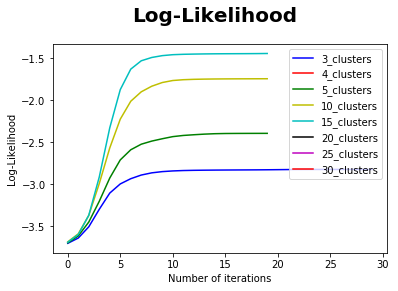

In [69]:
fig = plt.figure()
fig.suptitle('Log-Likelihood', fontsize=20, fontweight='bold')
ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Log-Likelihood')
three_clusters, = ax.plot(LogLik_3, 'b')
#four_clusters, = ax.plot(LogLik_4, 'r')
five_clusters, = ax.plot(LogLik_5, 'g')
ten_clusters, = ax.plot(LogLik_10, 'y')
fifteen_clusters, = ax.plot(LogLik_15, 'c')
#twenty_clusters, = ax.plot(LogLik_20, 'k')
twentyfive_clusters, = ax.plot(LogLik_25, 'm')
thirty_clusters, = ax.plot(LogLik_30, 'r')
ax.legend([
    three_clusters, four_clusters, five_clusters, ten_clusters,
    fifteen_clusters, twenty_clusters, twentyfive_clusters, thirty_clusters
], [
    '3_clusters', '4_clusters', '5_clusters', '10_clusters', '15_clusters',
    '20_clusters', '25_clusters', '30_clusters'
])
plt.savefig('nb_cluster_comparison.png')
plt.show()

## 3. Build the Recommendation System

In [46]:
rdd = sc.textFile("ratings.csv")

#Remove header line 
header = rdd.first()
rdd = rdd.filter(lambda x: x != header)
rdd = rdd.map(lambda line : line.split(','))
rdd = rdd.map(lambda line : (line[0], line[2]))

Let us build an rdd with every possible combination of (user, movie) so that we can compute the probability that a user has been or will be watching the movie. In order to do so, we will use the hidden variables Z (the classes) that will help us in the computation of the probability. Thus, we need to build an rdd with every possible combination of ((user, movie), class) : 

In [47]:
users = rdd.map(lambda x : x[0])
movies = rdd.map(lambda x : x[1])
classes = sc.parallelize(range(nb_z))

In [48]:
data = users.cartesian(movies)
data = data.cartesian(classes).map(lambda line : (line[0][0], line[0][1], line[1]))
data = data.distinct()

We can now compute the probability that a user has been or will be watching a movie using the hidden variables : : p(movie | user) = p(movie | class) * p(class | movie) : 

In [49]:
ordered_data = data.sortBy(lambda x : (x[0], x[1], x[2]))

In [50]:
couples = ordered_data.map(lambda x : ((x[2], x[0]), (x[1], x[2])))

In [51]:
probas = couples.join(Pzu).map(lambda x : (x[1][0], (x[0], x[1][1])))

In [52]:
probas = probas.join(Psz)

In [53]:
Psu = probas.map(lambda x : (x[1][0][0][1], x[0][0], x[1][0][1]*x[1][1]))

In [54]:
probs = Psu.map(lambda x : x[2])

Let us plot the distribution of the probabilities to see what's going on : 

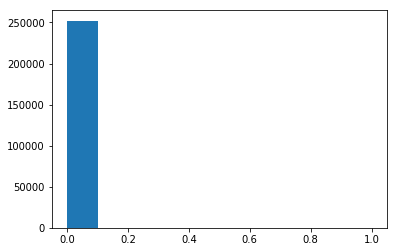

In [55]:
plt.hist(probs.collect())
plt.savefig("probas_distrib.png")

Given the above plot, we decide to set the treshold at 0.02. If the probability of the movie given the user is higher than 0.02, we can advise this movie to the user. 

In [56]:
def prediction(rdd, threshold):
    return(rdd.map(lambda x : (x[0],x[1], x[2] >=threshold)))

Here is the final result of our prediction : 'False' indicates that there is very little chance that the user sees that movie, 'True' indicates that the user should see that movie. 

In [57]:
result = prediction(Psu, 0.02)
result.collect()[0:10]

[('109', '2885', False),
 ('11', '2885', False),
 ('197', '2885', False),
 ('295', '2885', False),
 ('39', '2885', False),
 ('466', '2885', False),
 ('500', '2885', False),
 ('507', '2885', False),
 ('661', '2885', False),
 ('775', '2885', False)]